Analyse the sequence of pos and velo of 10000 ions in a short period with small steps

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import matplotlib.cm as cm

start = 3444.983#405.719#172.201#547.126 #us
dt = 9.022389064166401e-03 #us, interval*dt
N = 10000
config_name = "flat_28"
data_source = "traj" #"status"
dir_name = "../data_cache/%d/%s/%s"%(N, data_source, config_name)
Nt = len(list(os.listdir(dir_name+"/r")))
t_ls = np.arange(1, Nt+1)*dt + start
print(np.min(t_ls), np.max(t_ls))
def load_traj(ion_id=0):
    traj_r = np.zeros((Nt, 3))
    traj_v = np.zeros((Nt, 3))
    for t in range(Nt):
        rt = np.load(dir_name+"/r/%.3fus.npy"%t_ls[t])
        vt = np.load(dir_name+"/v/%.3fus.npy"%t_ls[t])
        traj_r[t] = rt[ion_id]
        traj_v[t] = vt[ion_id]
    return traj_r, traj_v

label_list = ['x', 'y', 'z']

def analyse(axis, mode='r', ion_id=0):
    traj_r, traj_v = load_traj(ion_id)
    fig, ax = plt.subplots(figsize=(20, 10))
    if mode == 'r':
        ax.plot(t_ls, traj_r[:, axis])
        ax.set_xlabel("t/us")
        ax.set_ylabel("%s/um"%label_list[axis])
    elif mode == 'v':
        ax.plot(t_ls, traj_v[:, axis])
        ax.set_xlabel("t/us")
        ax.set_ylabel("v%s/(m/s)"%label_list[axis])
    plt.show()

def analyse_freq(axis, mode='r', ion_id=0, plot=True):
    traj_r, traj_v = load_traj(ion_id)
    Dt = dt
    fs = 1/Dt # Sampling frequency
    seq = traj_r[:, axis] if mode =='r' else traj_v[:, axis]
    freq = np.fft.fft(seq)
    Ns = len(freq)
    freqs = np.fft.fftfreq(Ns, 1/fs)  # 频率轴
    magnitude = np.abs(freq) / Ns  # 幅度谱（归一化）

    # 只绘制正频率部分
    half_Ns = Ns // 2
    freqs = freqs[:half_Ns]
    magnitude = magnitude[:half_Ns]

    if plot:
        fig, ax = plt.subplots(2,1, figsize=(12, 6))
        # 绘制时域信号
        ax[0].plot(t_ls, seq)
        ax[0].set_title("Signal")
        ax[0].set_xlabel("Time")
        ax[0].set_ylabel("Amplitude")

        # 绘制频域幅度谱
        ax[1].stem(freqs, magnitude, basefmt=" ")
        ax[1].set_title("Freq spectral")
        ax[1].set_xlabel("Freq (MHz)")
        ax[1].set_ylabel("Amplitude")
        fig.suptitle("%s direction, %dth ion, mode=%s"%(label_list[axis], ion_id, mode))
        plt.tight_layout()
        plt.show()

    return freqs, magnitude

def freq_segment(axis=0, ion_id=0, min_freq=0, max_freq=100):
    freqs, magnitude = analyse_freq(axis=axis, mode='v', ion_id=ion_id, plot=False) # defaut mode='v', as no low frequency bias
    mask = (freqs >= min_freq) & (freqs <= max_freq)
    freqs_low = freqs[mask]
    magnitude_low = magnitude[mask]
    fig, ax = plt.subplots(figsize=(20, 10))
    peaks, _ = find_peaks(magnitude_low)
    peak_freq = freqs_low[peaks] if len(peaks)>0 else []
    peak_magnitude = magnitude_low[peaks] if len(peaks)>0 else []
    ax.plot(freqs_low, magnitude_low)
    ax.set_xlabel("freq/MHz")
    ax.set_ylabel("amplitude")
    ax.set_title("%s direction, %dth ion, mode=%s"%(label_list[axis], ion_id, 'v'))
    plt.show()
    return peak_freq, peak_magnitude

def pick_up_ion(ion_id, mask = None):
    r = np.load(dir_name+"/r/%.3fus.npy"%t_ls[-1])
    if mask.all() != None:
        r = r[mask, :]
    fig, ax = plt.subplots(figsize=(20, 10))
    colors = np.full(r.shape[0], 'b')
    colors[ion_id] = 'r'
    sc = ax.scatter(r[:,2], r[:, 0], s=5, c=colors)
    ax.set_xlabel("z/um")
    ax.set_ylabel("x/um")
    ax.set_aspect("equal")
    plt.show()

def colored_crystal(metric, r=None, t_frame=t_ls[-1], metric_name=''):
    if r is None:
        r = np.load(dir_name+"/r/%.3fus.npy"%t_frame)
    fig, ax = plt.subplots(figsize=(20, 10))
    cmap = cm.RdBu
    colors = metric
    sc = ax.scatter(r[:,2], r[:, 0], s=5, c=colors, cmap=cmap)
    ax.set_xlabel("z/um")
    ax.set_ylabel("x/um")
    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
    cbar.set_label(metric_name)
    ax.set_aspect("equal")
    plt.show()
print(Nt)

3444.9920223890645 3550.5449520507473
11700


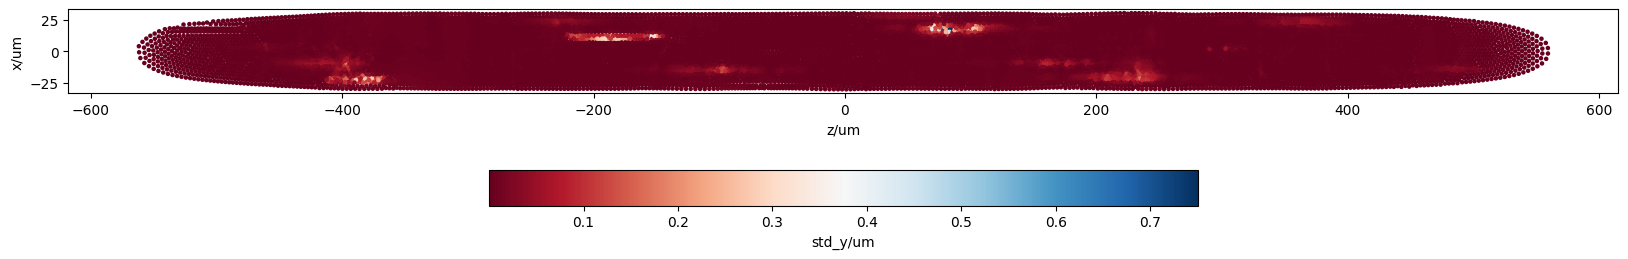

In [13]:
# Mean pos

r = np.zeros((Nt, N, 3))
for t in range(Nt):
    r[t] = np.load(dir_name+"/r/%.3fus.npy"%t_ls[t])
mean_r = np.mean(r, axis=0)
mask = np.abs(mean_r[:,0])<200
mean_r = mean_r[mask]
dr = r[:, mask, :] - mean_r[np.newaxis, :, :]
std_r = np.std(dr, axis=0)
# plt.scatter(mean_r[:,2], mean_r[:,0], c='b', s=5)
colored_crystal(std_r[:, 1], r=mean_r, metric_name='std_y/um')

(9821, 3)


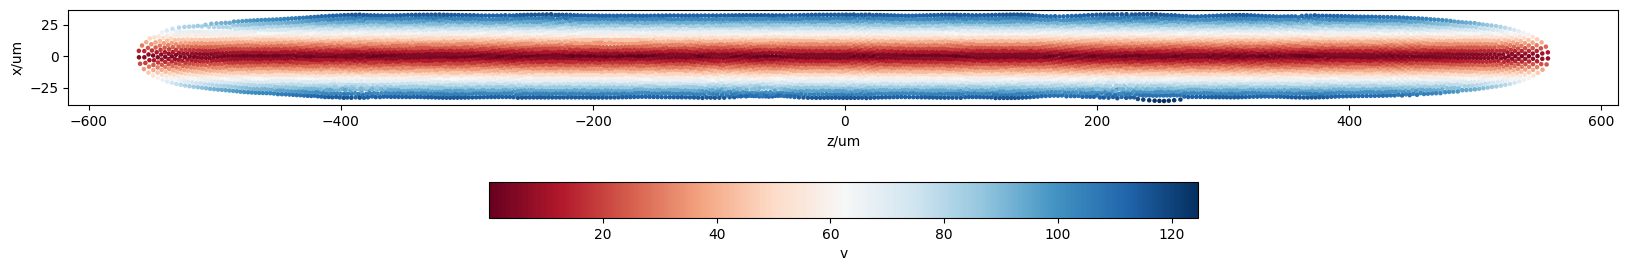

In [ ]:
t_frame = 3444.983
v = np.load(dir_name+"/v/%.3fus.npy"%t_frame)
r = np.load(dir_name+"/r/%.3fus.npy"%t_frame)
mask = (np.abs(r[:,0])<50) & (np.abs(r[:,1])<20) &(np.abs(r[:, 2])<600)
r = r[mask]
v = v[mask]
v_norm = np.linalg.norm(v, axis=1)
print(r.shape)
fig, ax = plt.subplots(figsize=(20, 10))
cmap = cm.RdBu
sc = ax.scatter(r[:,2], r[:, 0], s=5, c=v_norm, cmap=cmap)
ax.set_xlabel("z/um")
ax.set_ylabel("x/um")
cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
cbar.set_label('v')
ax.set_aspect("equal")
plt.show()

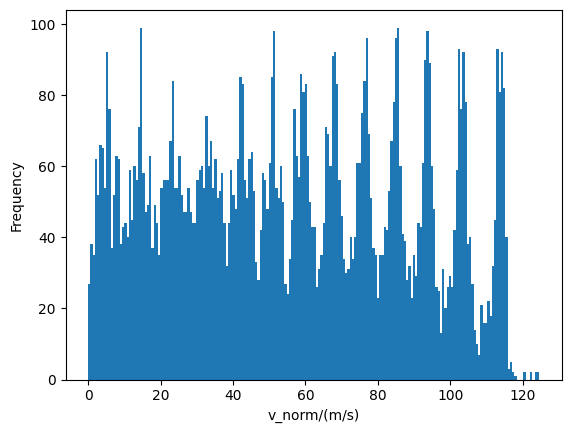

In [231]:
fig, ax = plt.subplots()
Nv, Ev, _ = ax.hist(v_norm, bins=200)    # Nv: frequency of each bin, Ev: Edge of each bin
ax.set_xlabel("v_norm/(m/s)")
ax.set_ylabel("Frequency")
plt.show()

In [234]:
import numpy as np
import matplotlib.pyplot as plt
Ni = N
v_rms = np.zeros(Ni)
v = np.zeros((Nt, Ni, 3))
for t in range(Nt):
    v[t] = np.load(dir_name+"/v/%.3fus.npy"%t_ls[t])
v_rms = np.sqrt(np.mean(np.sum(v**2, axis=2), axis=0))
vx_rms = np.sqrt(np.mean(v[:,:,0]**2, axis=0))
vy_rms = np.sqrt(np.mean(v[:,:,1]**2, axis=0))
vz_rms = np.sqrt(np.mean(v[:,:,2]**2, axis=0))

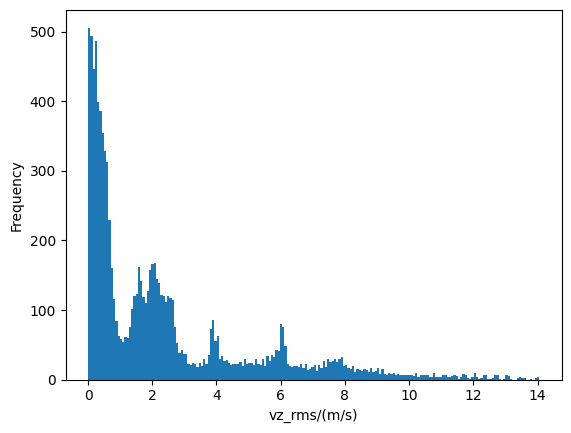

In [237]:
fig, ax = plt.subplots()
Nv, Ev, _ = ax.hist(vz_rms, bins=200)    # Nv: frequency of each bin, Ev: Edge of each bin
ax.set_xlabel("vz_rms/(m/s)")
ax.set_ylabel("Frequency")
plt.show()

In [204]:
print(np.mean(v_rms))

146.68593134911097


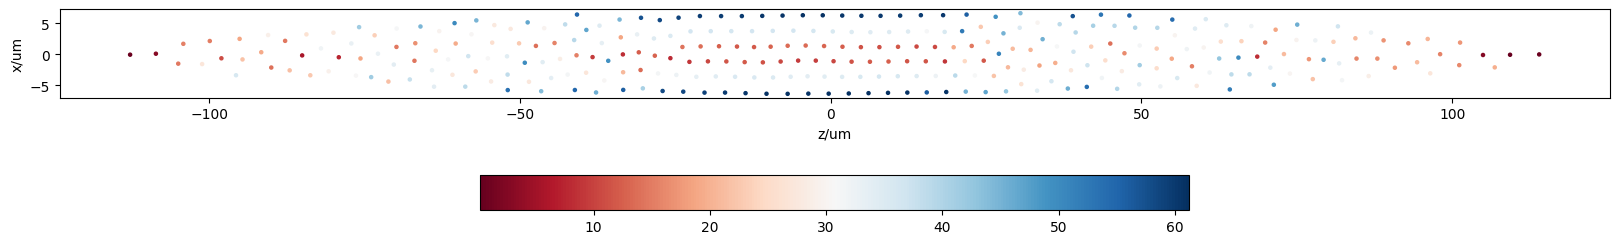

In [147]:
colored_crystal(v_rms)

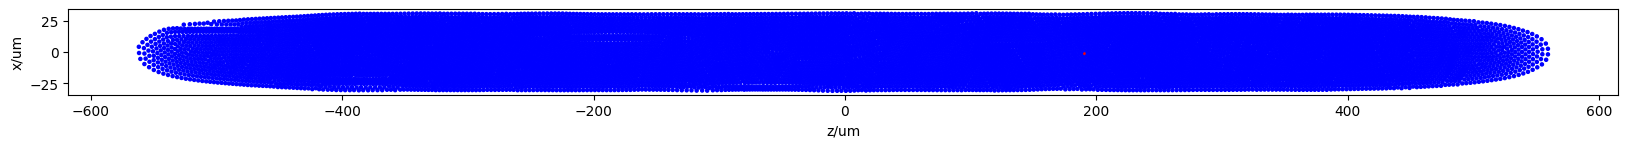

In [53]:
pick_up_ion(ion_id=0, mask=mask)

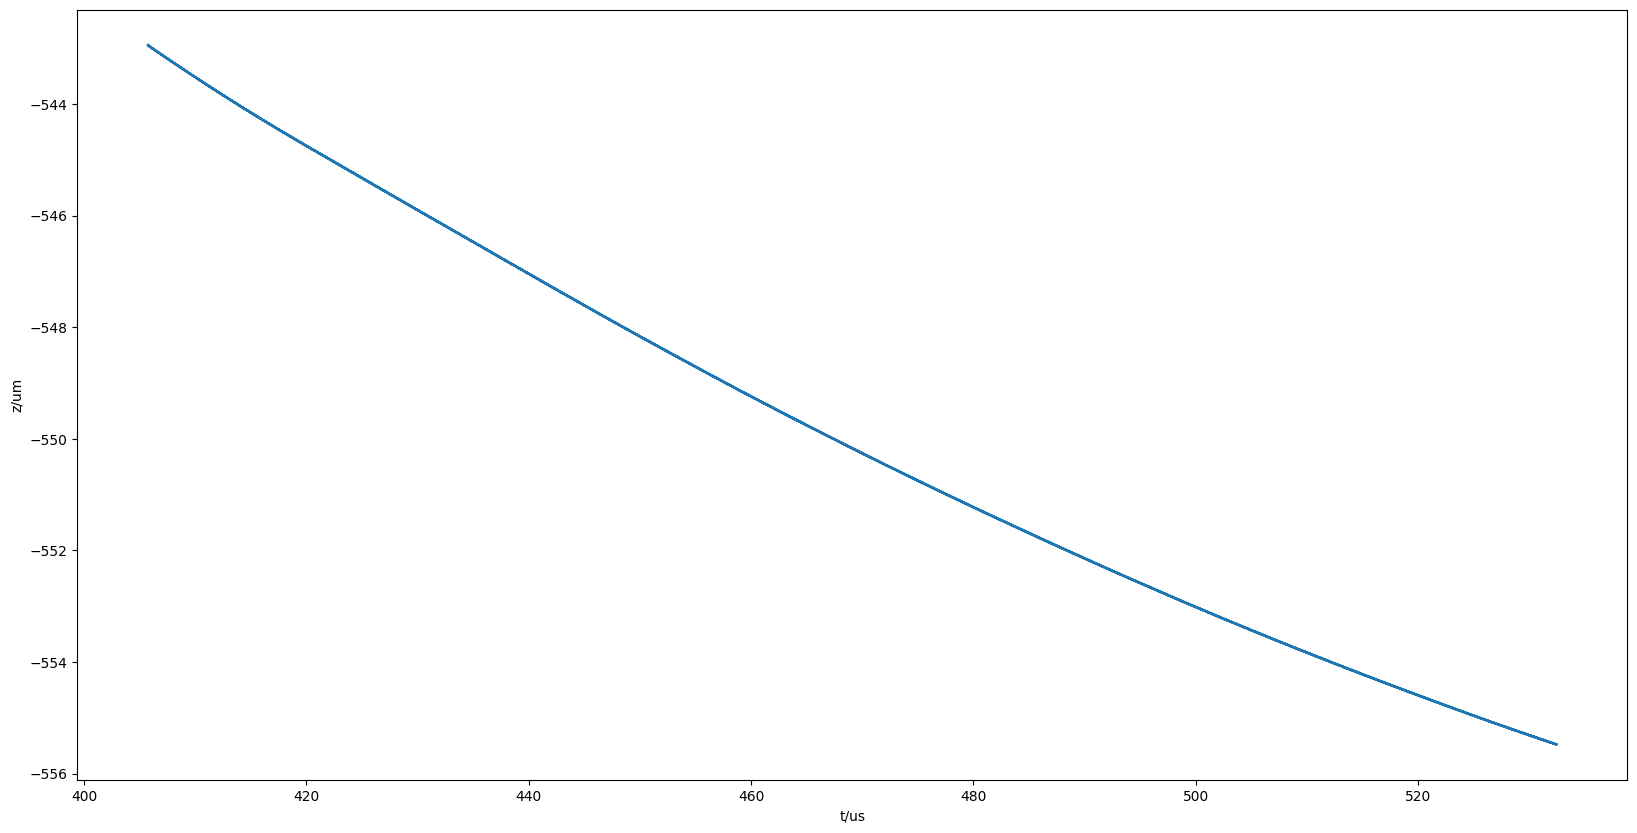

In [24]:
analyse(axis=2, mode='r', ion_id=0)

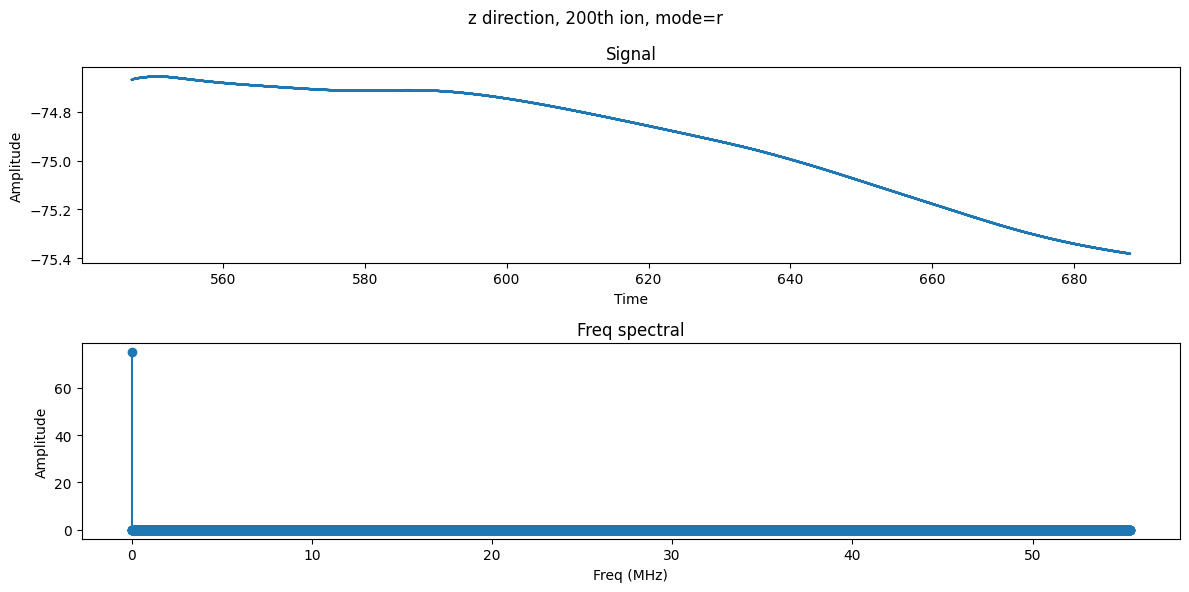

In [7]:
freqs, magnitude = analyse_freq(axis=2, mode='r', ion_id=200)

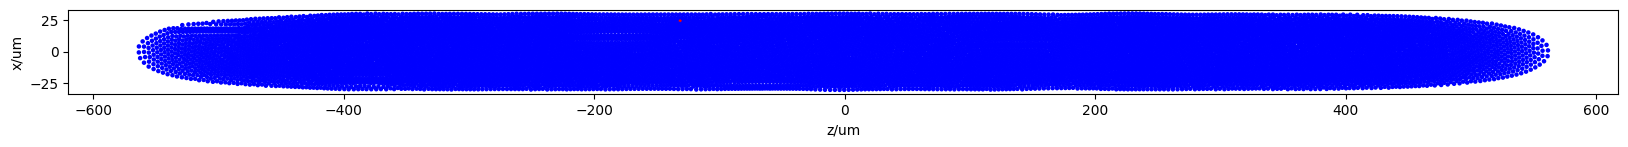

In [8]:
pick_up_ion(ion_id=3)

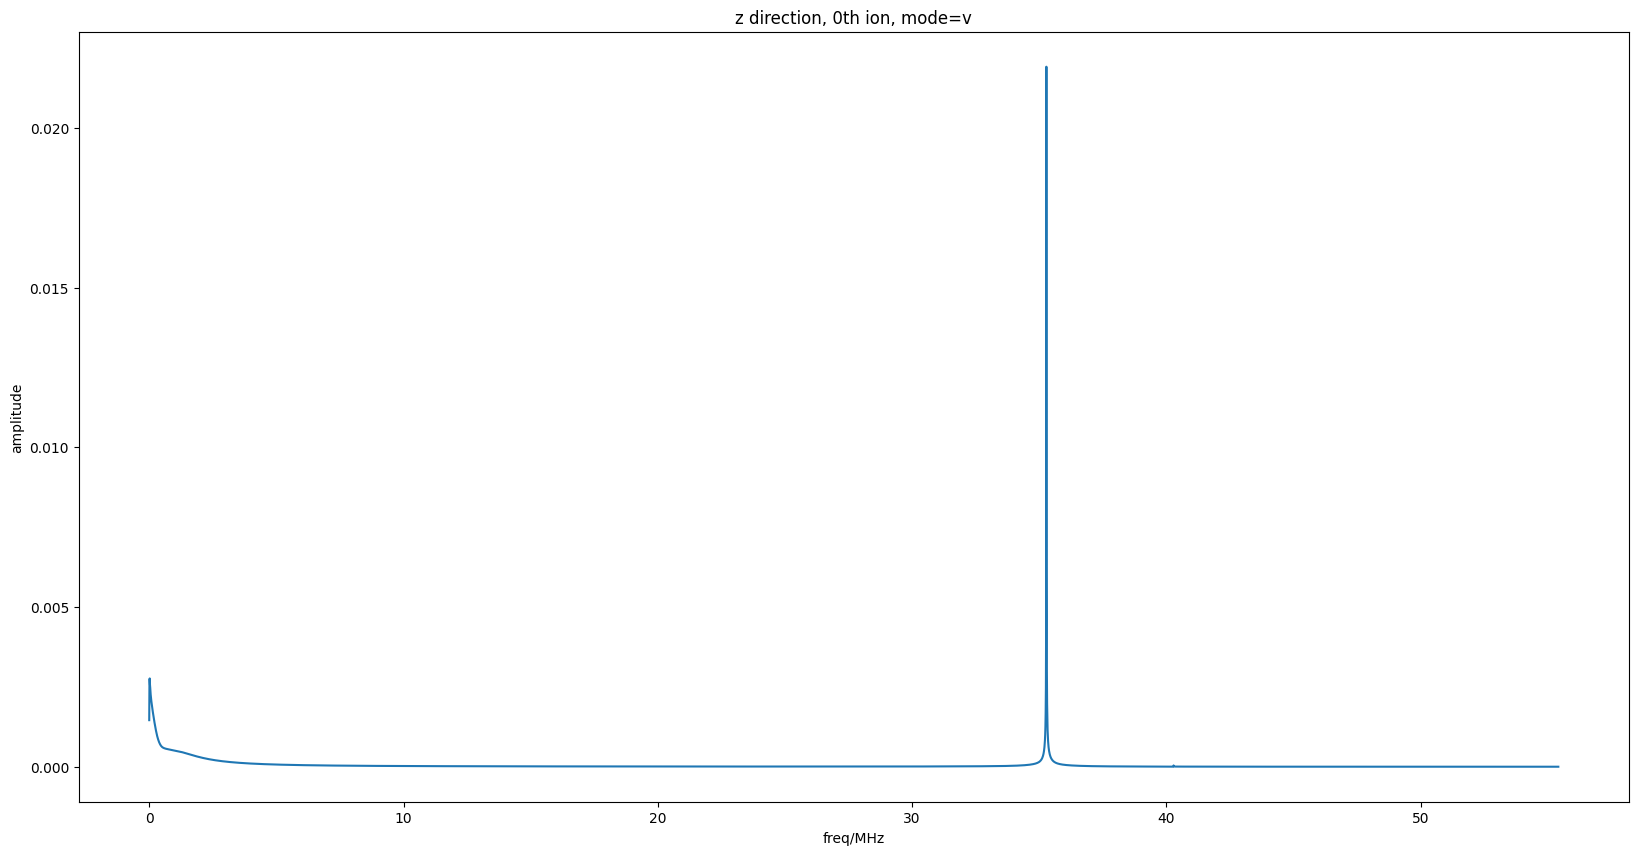

(array([1.89462203e-02, 3.52778622e+01, 4.02796644e+01]),
 array([2.76825095e-03, 2.19113158e-02, 4.65114022e-05]))

In [56]:
freq_segment(axis=2, ion_id=0)

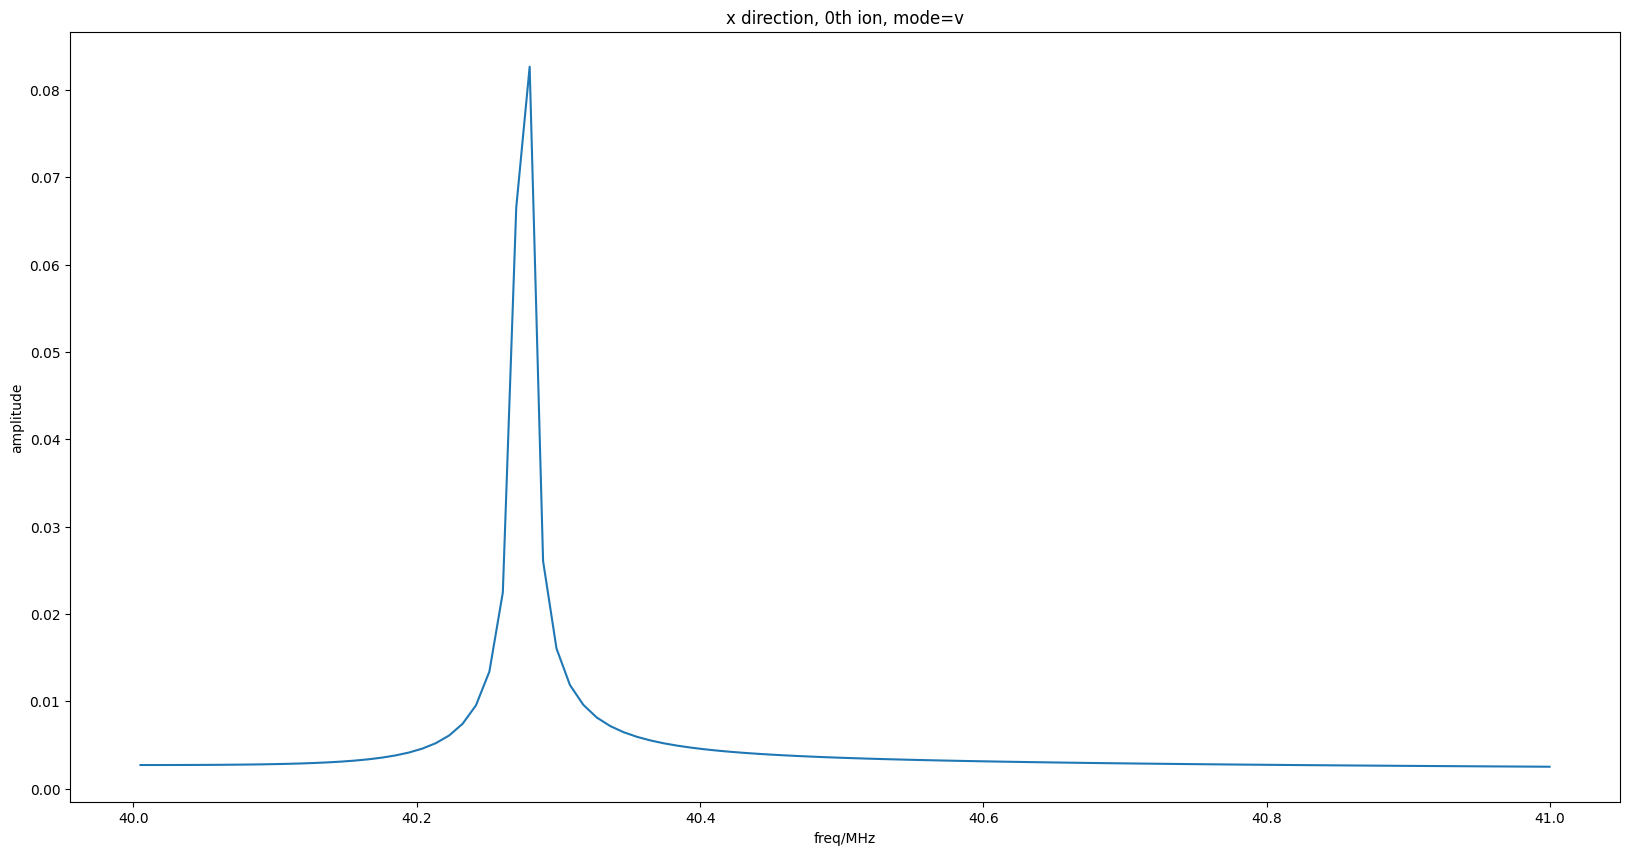

[40.27966438] [0.08266793]


In [69]:
peak_freq, peak_mag = freq_segment(axis=0, ion_id=0, min_freq=40, max_freq=41)
print(peak_freq, peak_mag)

11.083538881864792
221.6707776372958


Text(0, 0.5, 'Amplitude/a.u.')

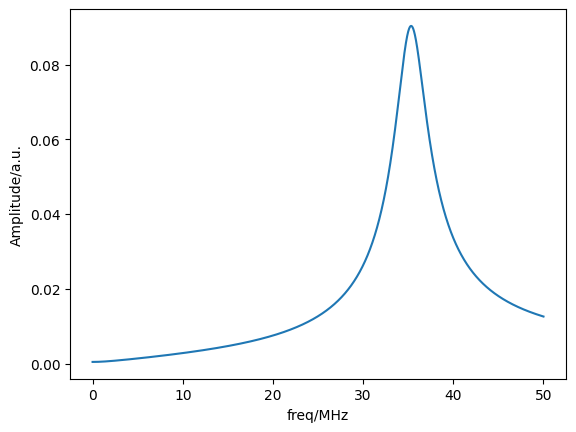

In [12]:
from scipy.constants import e, epsilon_0, pi
import numpy as np
import matplotlib.pyplot as plt
dl = 2.7437758083117576e-07
dt = 9.022389064166401e-09
# g0 = e**2*dt/(4*epsilon_0*pi*dl**3)/(1e6) #MHz
# g0 = e*dt/(dl**2)/(1e6) #MHz
g0 = 1/(dt*1e6) #MHz，γ对应角频率
g = 0.1*g0 #MHz
print(g)
w0 = 35.28*2*pi #MHz
print(w0)
def F(w):
    return abs(1/(g+1j*(w0+w))+1/(g-1j*(w0 - w)))
w_arr = np.linspace(0, 50, 100000)*2*pi
def F2(w):
    return 1/(g**2 + 2j*g*w0 + w**2 - w0**2) + 1/(g**2 - 2j*g*w0 + w**2 - w0**2) + 1/(g**2 + w**2 + 2*w*w0 + w0**2) + 1/(g**2 + w**2 - 2*w*w0 + w0**2)
min_bound = 34
max_bound = 36
mask = (w_arr>=2*pi*min_bound) & (w_arr<=2*pi*max_bound)
plt.plot(w_arr/(2*pi), F(w_arr))    #统一折算成线频率
plt.xlabel("freq/MHz")
plt.ylabel("Amplitude/a.u.")

In [33]:
from sympy import symbols, I, Abs
g, w0, w = symbols('g, w0, w', real=True)
Fw = Abs(1/(g+I*(w0+w))+1/(g - I*(w0 - w)))
print(Fw**2)

1/(g**2 + 2*I*g*w0 + w**2 - w0**2) + 1/(g**2 - 2*I*g*w0 + w**2 - w0**2) + 1/(g**2 + w**2 + 2*w*w0 + w0**2) + 1/(g**2 + w**2 - 2*w*w0 + w0**2)


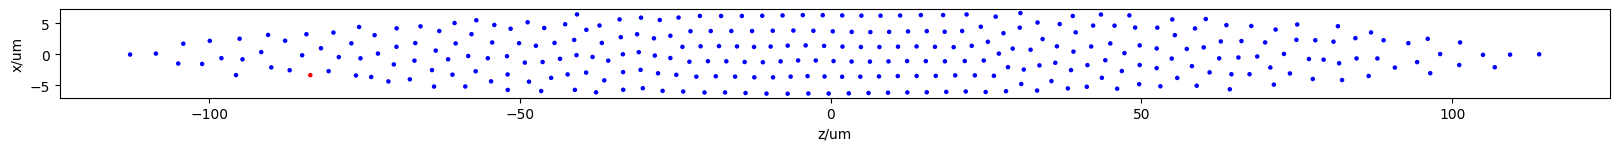

In [178]:
pick_up_ion(42)

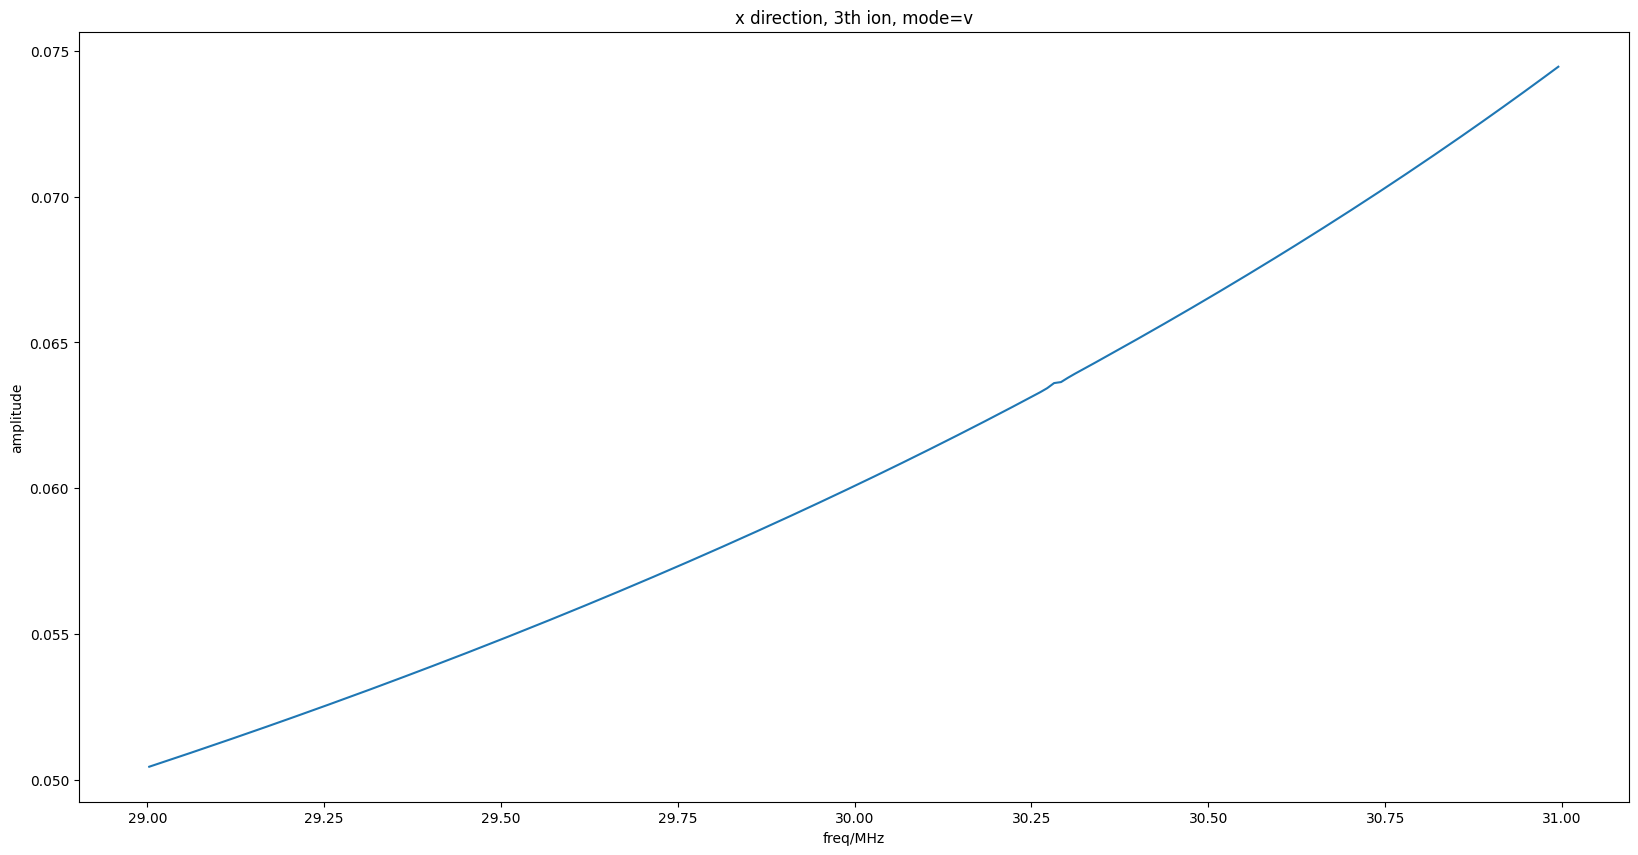

([], [])

In [138]:
freq_segment(axis=0, ion_id=3, min_freq=29, max_freq=31)

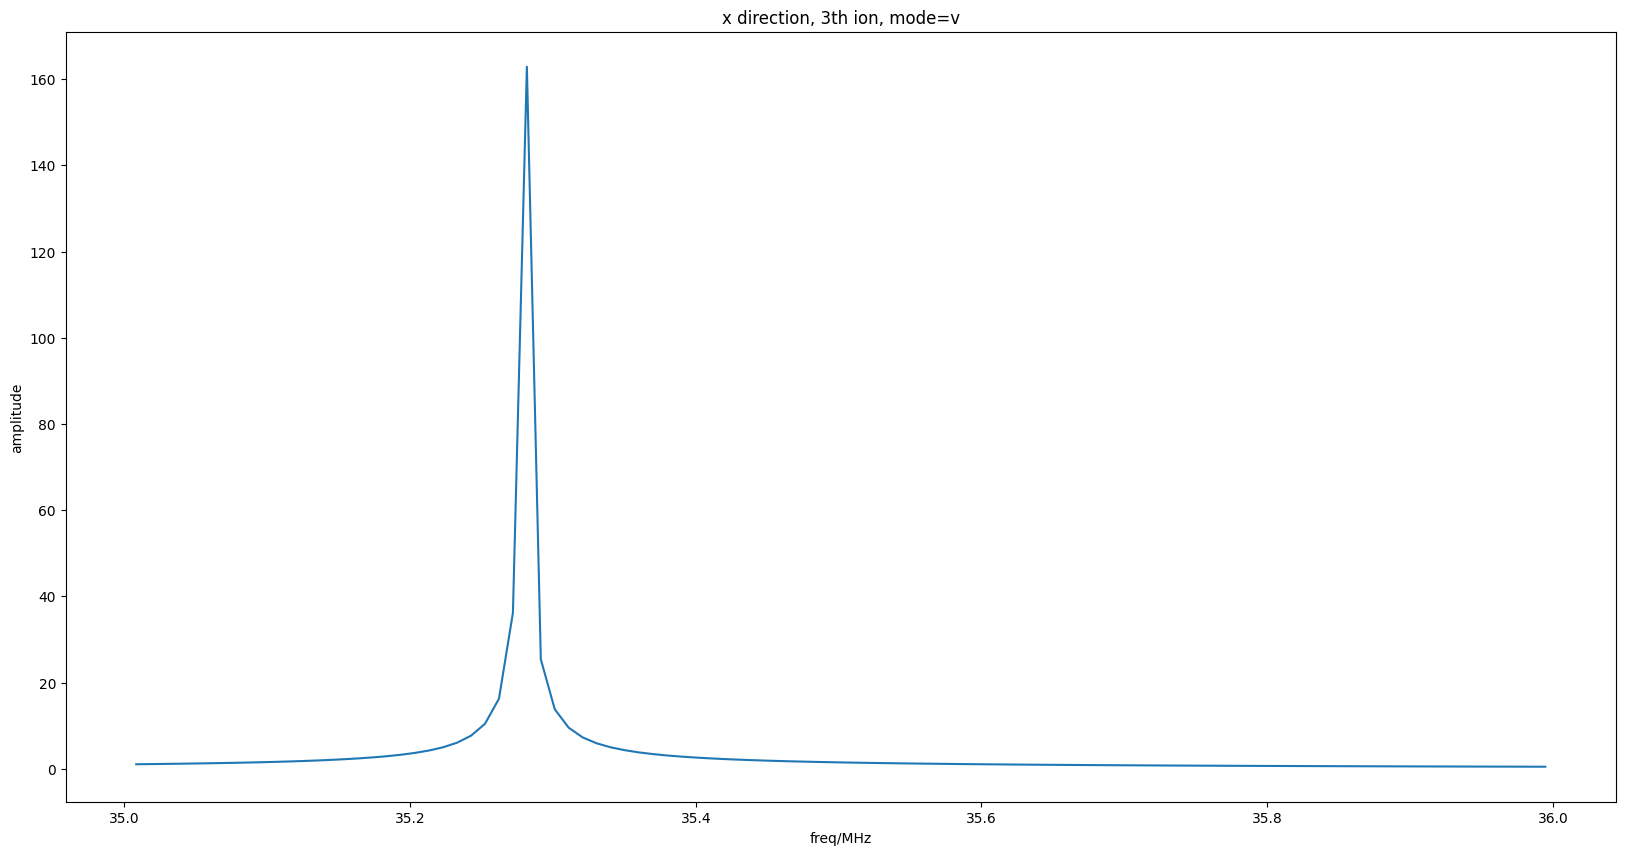

[35.281785] [162.89254207]


In [123]:
peak_freq, peak_mag = freq_segment(axis=0, ion_id=3, min_freq=35, max_freq=36)
print(peak_freq, peak_mag)

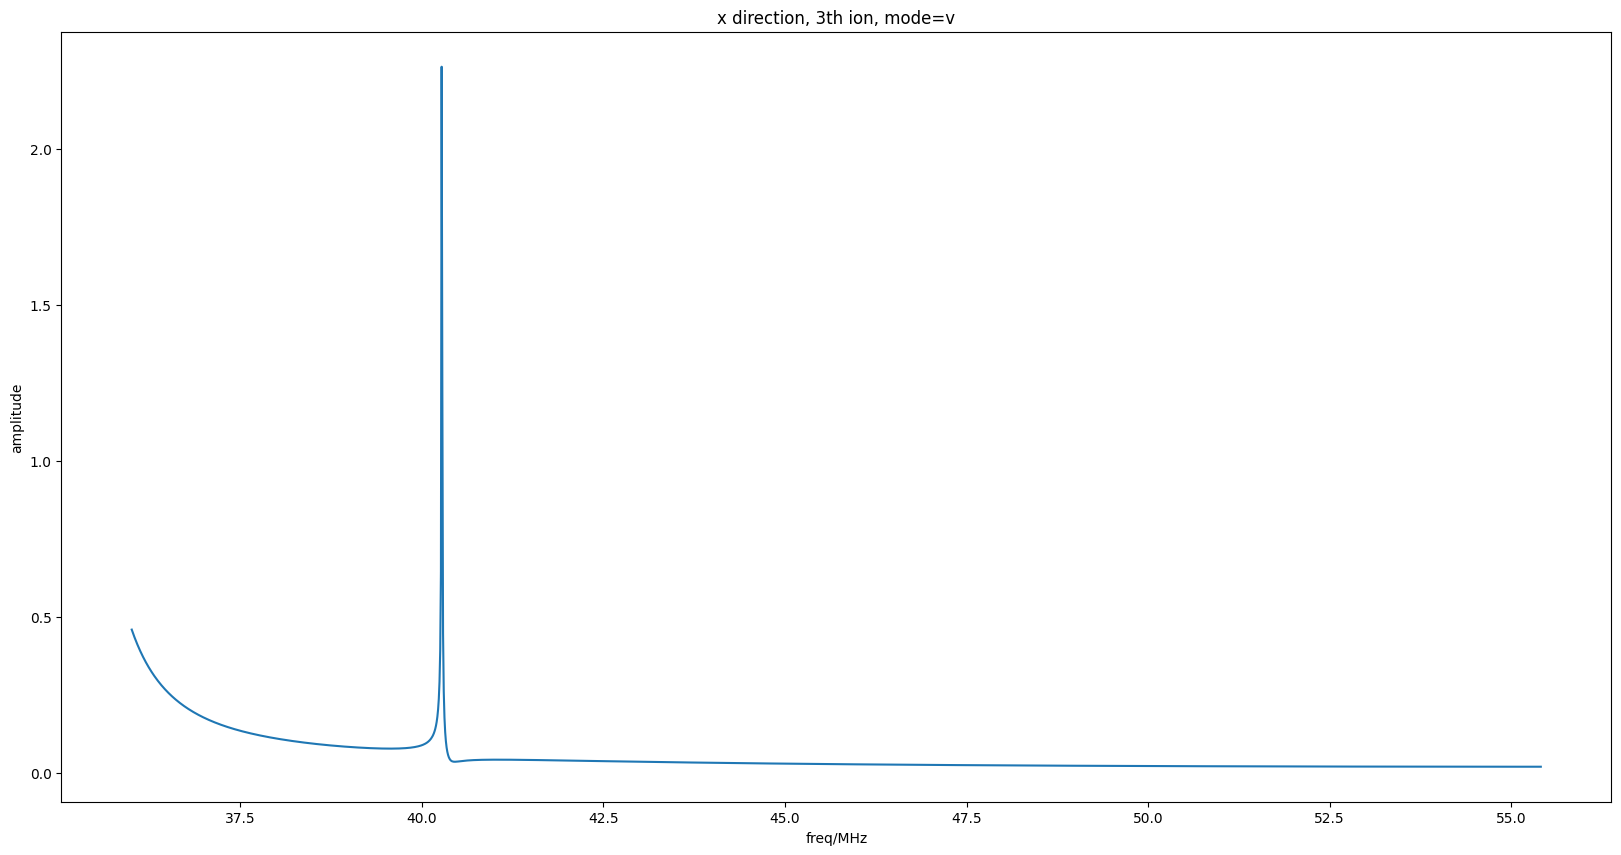

[40.27181881 41.04327218 45.28138308 54.93919802 54.95872848 55.24192022
 55.27121592 55.30051162] [2.26402503 0.04392057 0.03050421 0.02135591 0.02135666 0.02134138
 0.02134084 0.02133999]


In [122]:
peak_freq, peak_mag = freq_segment(axis=0, ion_id=3, min_freq=36, max_freq=100)
print(peak_freq, peak_mag)

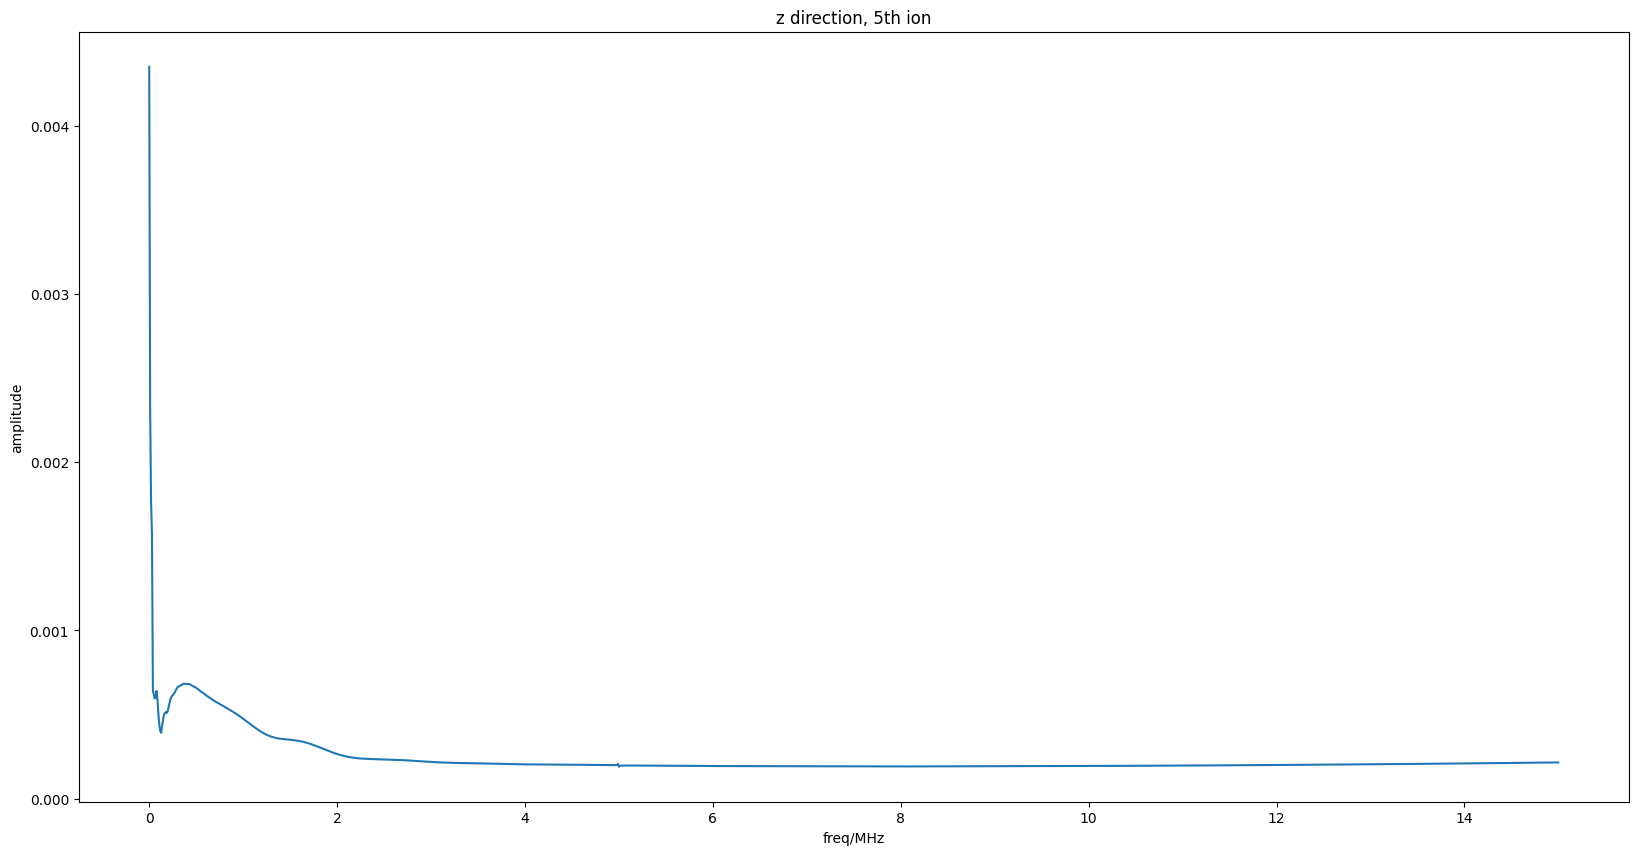

In [122]:
freq_segment(axis=2, ion_id=5, min_freq=0, max_freq=15)

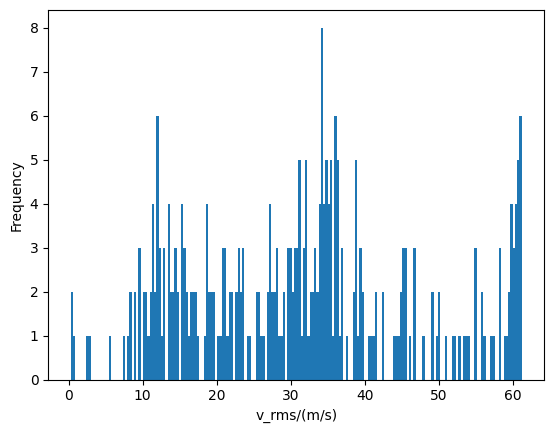

In [146]:
max_bin_id = np.argmax(Nv)
v_max = Ev[max_bin_id]
print(v_max)

34.085517459263436


In [27]:
from scipy.signal import find_peaks, peak_widths

peaks, _ = find_peaks(Nv, height=40, width=1)
print(peaks)
print(Ev[peaks])

widths, width_heights, left_ips, right_ips = peak_widths(Nv, peaks, rel_height=0.5)
print(Ev[int(left_ips[-1])], Ev[int(right_ips[-1])])
fwhm = right_ips - left_ips
print(fwhm)


[  4   9  13  15  23  28  36  42  45  52  55  60  67  72  81  94 100 108
 122 136 149 164 179]
[  7.05829802  15.32684697  21.94168614  25.24910572  38.47878405
  46.74733301  59.97701134  69.89927009  74.86039946  86.436368
  91.39749737  99.66604633 111.24201487 119.51056382 134.39395194
 155.89217923 165.81443798 179.04411631 202.19605338 225.34799046
 246.84621775 271.65186461 296.45751148]
294.80380169135043 303.07235064745714
[2.77302632 1.41468254 4.29761905 1.         2.90848806 2.54583333
 1.54694168 2.2        1.08333333 2.17929293 1.96875    1.7020202
 3.76754386 1.47777778 3.36651584 3.6        1.48717949 6.4375
 5.8125     5.59166667 5.33730159 5.05673759 5.07986111]


5 3 9 5
44.746721542473445 46.26975069721773 40.48223990918944 42.30987489488258


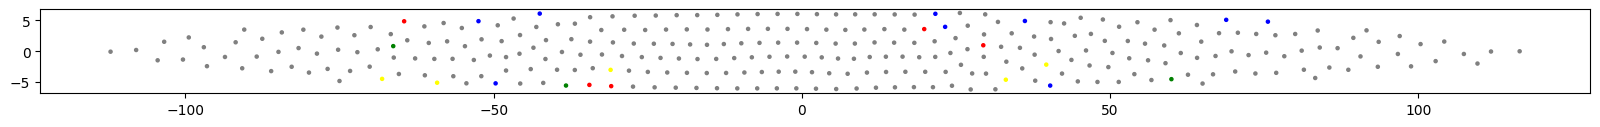

In [199]:
mask_1 = (v_rms>Ev[int(left_ips[-1])]) & (v_rms<Ev[int(right_ips[-1])])
ion_v1 = np.where(mask_1)[0]
mask_2 = (v_rms>Ev[int(left_ips[-2])]) & (v_rms<Ev[int(right_ips[-2])])
ion_v2 = np.where(mask_2)[0]
mask_3 = (v_rms>Ev[int(left_ips[-3])]) & (v_rms<Ev[int(right_ips[-3])])
ion_v3 = np.where(mask_3)[0]
mask_4 = (v_rms>Ev[int(left_ips[-4])]) & (v_rms<Ev[int(right_ips[-4])])
ion_v4 = np.where(mask_4)[0]
print(ion_v1.shape[0], ion_v2.shape[0], ion_v3.shape[0], ion_v4.shape[0])
print(Ev[int(left_ips[-3])], Ev[int(right_ips[-3])], Ev[int(left_ips[-4])], Ev[int(right_ips[-4])])
r = np.load(dir_name+"/r/%.3fus.npy"%t_ls[0])
fig, ax = plt.subplots(figsize=(20, 10))
colors = np.full(Ni, 'grey', dtype='object')
colors[ion_v1] = 'r'
colors[ion_v2] = 'g'
colors[ion_v3] = 'b'
colors[ion_v4] = 'yellow'
ax.scatter(r[:,2], r[:, 0], s=5, c=colors)
ax.set_aspect("equal")
plt.show()


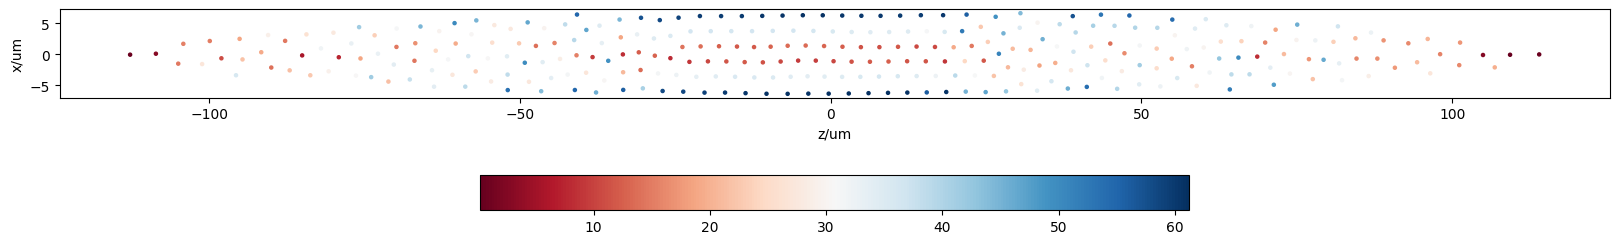

In [200]:
colored_crystal(metric=v_rms)